# Train LSTM model to Enduro sequence games

## Load libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import csv
import os
import cv2
from PIL import Image
from enduro_lstm import *

## Set to GPU if available

In [2]:
use_cuda = True
device = conf_cuda(use_cuda)

GPU is available


In [3]:
torch.cuda.empty_cache()

In [4]:
import gc
del model, X_train, Y_train
gc.collect()

NameError: name 'model' is not defined

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

## Set configurations

In [5]:
obs = 'play'
if obs == 'zigzag':
    zigzag = True
else:
    zigzag = False
zigzag

False

In [6]:
data_path = r"../1-generate/data/"
n_epochs = 5000
hidden_neurons = 500
stop_train = 1e-5

start_match = 45
end_match = 46

start_frame = 1
end_frame = 120

In [7]:
model_name = f"{obs}_m{start_match}to{end_match}_f{start_frame}to{end_frame}_epoch{n_epochs}_H{hidden_neurons}"
newpath = f"models/" + model_name
if not os.path.exists(newpath):
    print(f"models/" + model_name + " created")
    os.makedirs(newpath)
else:
    print(f"models/" + model_name)
    print("ATTENTION! folder not created. Training informations will overwrite the existing one")

models/play_m45to46_f1to120_epoch5000_H500
ATTENTION! folder not created. Training informations will overwrite the existing one


## Load frames and targets

In [8]:
ACTIONS_LIST = get_actions_list(zigzag=zigzag)

In [9]:
ACTIONS_LIST

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [10]:
num_of_frames_arr = []
frames_arr = []
actions_arr = []

for m in range(start_match, end_match + 1):
    
    num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, m)
    frames = frames[start_frame - 1:end_frame]
    actions = actions[start_frame - 1:end_frame]
    
    action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
    actions = np.array(action_one_hot)
    actions = actions.reshape(len(actions), -1)
    
    frames_arr.append(frames)
    actions_arr.append(actions)
    num_of_frames_arr.append(end_frame - start_frame + 1) 

Successfully loaded NPZ.
Successfully loaded NPZ.


In [11]:
X_train = np.array(frames_arr)/255
Y_train = np.array(actions_arr)
num_of_frames = np.array(num_of_frames_arr)

In [13]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

In [14]:
model = Model(device=device, input_size=20400, output_size=len(ACTIONS_LIST), hidden_dim=hidden_neurons, n_layers=1)

In [15]:
# We'll also set the model to the device that we defined earlier (default is CPU)
if use_cuda:
    model.cuda()
    X_train = X_train.cuda() 
    Y_train = Y_train.cuda()

In [16]:
min_loss = 1e-05
# Define Loss, Optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters())

In [17]:
loss_arr = np.array([])
acc_arr = np.array([])

In [24]:
import time
# Training Run

model.train()

epoch = 1
loss_file = open(newpath + '/' + "loss_file.txt", "w")

start_time_processing = time.time()
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    X_train.to(device)
    output, hidden = model(X_train)
    loss = criterion(output, Y_train.view(-1,len(ACTIONS_LIST)).float())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordinglyw
    
    if epoch%10 == 0:
        acc = float(torch.sum((torch.argmax(output, axis=1) == torch.argmax(Y_train.reshape(-1, len(ACTIONS_LIST)), axis=1).int())/num_of_frames.sum()))
        
        loss_file.write("Epoch: {}/{}.............".format(epoch, n_epochs))
        loss_file.write("Loss: {:.15f} Acc: {:.15f}\n".format(loss.item(), acc))
        
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.15f} Acc: {:.15f}".format(loss.item(), acc))
        
        loss_arr = np.append(loss_arr, loss.item())
        acc_arr = np.append(loss_arr, loss.item())
        
        if loss.item() < loss_arr[-1]:
            torch.save(model.state_dict(), newpath + '/' + model_name)
        
        if (acc_arr[-1] - acc > 0.2) or (loss.item() < min_loss):
            break
        
loss_file.close()
np.savez(newpath + '/' + "loss_arr", loss_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

Epoch: 10/5000............. Loss: 0.033042892813683 Acc: 0.795833349227905


KeyboardInterrupt: 

In [53]:
import time
# Training Run

model.train()

loss_file = open(newpath + '/' + "loss_file.txt", "a")

start_time_processing = time.time()

for epoch in range(n_epochs, n_epochs + n_epochs):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    X_train.to(device)
    output, hidden = model(X_train)
    loss = criterion(output, Y_train.view(-1,len(ACTIONS_LIST)).float())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordinglyw
    
    if epoch%10 == 0:
        acc = float((torch.sum((torch.argmax(output, axis=1) == torch.argmax(Y_train.squeeze(), axis=1)).int())/num_of_frames))
        
        loss_file.write("Epoch: {}/{}.............".format(epoch, n_epochs))
        loss_file.write("Loss: {:.15f} Acc: {:.15f}\n".format(loss.item(), acc))
        
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.15f} Acc: {:.15f}".format(loss.item(), acc))
        
        loss_arr = np.append(loss_arr, loss.item())
        
        if loss.item() < min_loss:
            break;

loss_file.close()

np.savez("loss_arr", loss_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

Epoch: 5000/5000............. Loss: 0.005877292249352 Acc: 0.974000036716461
Epoch: 5010/5000............. Loss: 0.005845887120813 Acc: 0.974000036716461
Epoch: 5020/5000............. Loss: 0.005834993440658 Acc: 0.974000036716461
Epoch: 5030/5000............. Loss: 0.005823079962283 Acc: 0.974000036716461
Epoch: 5040/5000............. Loss: 0.005804914981127 Acc: 0.974000036716461
Epoch: 5050/5000............. Loss: 0.005812513642013 Acc: 0.974000036716461
Epoch: 5060/5000............. Loss: 0.005777860060334 Acc: 0.974000036716461
Epoch: 5070/5000............. Loss: 0.005793835967779 Acc: 0.974000036716461
Epoch: 5080/5000............. Loss: 0.005757186561823 Acc: 0.974000036716461
Epoch: 5090/5000............. Loss: 0.005741617176682 Acc: 0.974000036716461
Epoch: 5100/5000............. Loss: 0.005744447000325 Acc: 0.974000036716461
Epoch: 5110/5000............. Loss: 0.005714338272810 Acc: 0.974000036716461
Epoch: 5120/5000............. Loss: 0.005710159428418 Acc: 0.974000036716461

Epoch: 6070/5000............. Loss: 0.004679769743234 Acc: 0.975000023841858
Epoch: 6080/5000............. Loss: 0.004681862890720 Acc: 0.975000023841858
Epoch: 6090/5000............. Loss: 0.004689858295023 Acc: 0.975000023841858
Epoch: 6100/5000............. Loss: 0.004660923965275 Acc: 0.975000023841858
Epoch: 6110/5000............. Loss: 0.004652451723814 Acc: 0.975000023841858
Epoch: 6120/5000............. Loss: 0.004661440849304 Acc: 0.975000023841858
Epoch: 6130/5000............. Loss: 0.004652219824493 Acc: 0.975000023841858
Epoch: 6140/5000............. Loss: 0.004647481255233 Acc: 0.975000023841858
Epoch: 6150/5000............. Loss: 0.004622885957360 Acc: 0.975000023841858
Epoch: 6160/5000............. Loss: 0.004644937347621 Acc: 0.975000023841858
Epoch: 6170/5000............. Loss: 0.004628297872841 Acc: 0.975000023841858
Epoch: 6180/5000............. Loss: 0.004609891213477 Acc: 0.975000023841858
Epoch: 6190/5000............. Loss: 0.004595585167408 Acc: 0.975000023841858

Epoch: 7140/5000............. Loss: 0.015314494259655 Acc: 0.932000041007996
Epoch: 7150/5000............. Loss: 0.015272896736860 Acc: 0.932000041007996
Epoch: 7160/5000............. Loss: 0.015231098048389 Acc: 0.932000041007996
Epoch: 7170/5000............. Loss: 0.015190667472780 Acc: 0.932000041007996
Epoch: 7180/5000............. Loss: 0.015150351449847 Acc: 0.932000041007996
Epoch: 7190/5000............. Loss: 0.015110809355974 Acc: 0.932000041007996
Epoch: 7200/5000............. Loss: 0.015071650035679 Acc: 0.932000041007996
Epoch: 7210/5000............. Loss: 0.015033110044897 Acc: 0.932000041007996
Epoch: 7220/5000............. Loss: 0.014995005913079 Acc: 0.932000041007996
Epoch: 7230/5000............. Loss: 0.014957404695451 Acc: 0.932000041007996
Epoch: 7240/5000............. Loss: 0.014920278452337 Acc: 0.932000041007996
Epoch: 7250/5000............. Loss: 0.014883614145219 Acc: 0.932000041007996
Epoch: 7260/5000............. Loss: 0.014847365207970 Acc: 0.932000041007996

Epoch: 8210/5000............. Loss: 0.012419621460140 Acc: 0.932000041007996
Epoch: 8220/5000............. Loss: 0.012550890445709 Acc: 0.932000041007996
Epoch: 8230/5000............. Loss: 0.012342417612672 Acc: 0.932000041007996
Epoch: 8240/5000............. Loss: 0.012741670943797 Acc: 0.932000041007996
Epoch: 8250/5000............. Loss: 0.013240065425634 Acc: 0.932000041007996
Epoch: 8260/5000............. Loss: 0.013011164031923 Acc: 0.932000041007996
Epoch: 8270/5000............. Loss: 0.012888725847006 Acc: 0.932000041007996
Epoch: 8280/5000............. Loss: 0.012641664594412 Acc: 0.932000041007996
Epoch: 8290/5000............. Loss: 0.012249581515789 Acc: 0.932000041007996
Epoch: 8300/5000............. Loss: 0.012600594200194 Acc: 0.932000041007996
Epoch: 8310/5000............. Loss: 0.012308590114117 Acc: 0.932000041007996
Epoch: 8320/5000............. Loss: 0.012208680622280 Acc: 0.932000041007996
Epoch: 8330/5000............. Loss: 0.012556011788547 Acc: 0.932000041007996

Epoch: 9280/5000............. Loss: 0.010841665789485 Acc: 0.933000028133392
Epoch: 9290/5000............. Loss: 0.010831148363650 Acc: 0.933000028133392
Epoch: 9300/5000............. Loss: 0.010821922682226 Acc: 0.933000028133392
Epoch: 9310/5000............. Loss: 0.010812968946993 Acc: 0.933000028133392
Epoch: 9320/5000............. Loss: 0.010804108344018 Acc: 0.933000028133392
Epoch: 9330/5000............. Loss: 0.010795302689075 Acc: 0.933000028133392
Epoch: 9340/5000............. Loss: 0.010786544531584 Acc: 0.933000028133392
Epoch: 9350/5000............. Loss: 0.010777830146253 Acc: 0.933000028133392
Epoch: 9360/5000............. Loss: 0.010769160464406 Acc: 0.933000028133392
Epoch: 9370/5000............. Loss: 0.010760531760752 Acc: 0.933000028133392
Epoch: 9380/5000............. Loss: 0.010751940310001 Acc: 0.933000028133392
Epoch: 9390/5000............. Loss: 0.010743386112154 Acc: 0.933000028133392
Epoch: 9400/5000............. Loss: 0.010734865441918 Acc: 0.933000028133392

In [54]:
torch.save(model.state_dict(), newpath + '/' + model_name)

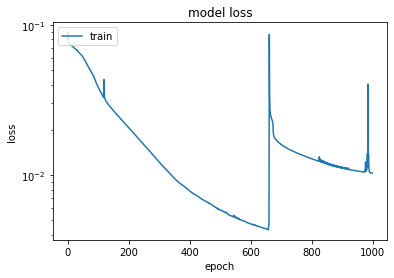

In [55]:
import matplotlib.pyplot as plt
# summarize history for loss
g = list(loss_arr)
plt.plot(loss_arr)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.yscale('log')
plt.savefig(newpath + '/' + 'perf.png')
plt.show()

In [56]:
model.eval() # eval mode
out, hidden = model(X_train)

In [57]:
for i in range(num_of_frames):
    print(str(i) + " -> " + str(torch.argmax(out[i])) + " -> " + str(torch.argmax(Y_train)))

0 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
1 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
2 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
3 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
4 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
5 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
6 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
7 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
8 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
9 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
10 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
11 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
12 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
13 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
14 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
15 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
16

164 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
165 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
166 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
167 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
168 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
169 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
170 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
171 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
172 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
173 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
174 -> tensor(2, device='cuda:0') -> tensor(0, device='cuda:0')
175 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
176 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
177 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
178 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
179 -> tensor(0, device='cuda:0') -> ten

322 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
323 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
324 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
325 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
326 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
327 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
328 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
329 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
330 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
331 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
332 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
333 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
334 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
335 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
336 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
337 -> tensor(3, device='cuda:0') -> ten

471 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
472 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
473 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
474 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
475 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
476 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
477 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
478 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
479 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
480 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
481 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
482 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
483 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
484 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
485 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
486 -> tensor(0, device='cuda:0') -> ten

629 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
630 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
631 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
632 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
633 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
634 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
635 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
636 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
637 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
638 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
639 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
640 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
641 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
642 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
643 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
644 -> tensor(1, device='cuda:0') -> ten

780 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
781 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
782 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
783 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
784 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
785 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
786 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
787 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
788 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
789 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
790 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
791 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
792 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
793 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
794 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
795 -> tensor(0, device='cuda:0') -> ten

922 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
923 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
924 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
925 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
926 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
927 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
928 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
929 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
930 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
931 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
932 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
933 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
934 -> tensor(2, device='cuda:0') -> tensor(0, device='cuda:0')
935 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
936 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
937 -> tensor(1, device='cuda:0') -> ten